In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier # using 1NN

# 1. Download the [cow teat datasets](https://github.com/YoushanZhang/SCTL) (10 points) resize image to (224, 224)

### (1). Create a train data loader that returns image arrays and labels
### (2). Create a test data loader that returns image arrays and file names
### (3). Print image arrays, labels and file names dimensions 

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Custom Dataset class for handling both labeled and unlabeled data
class CowTeatDataset(Dataset):
    def __init__(self, image_dirs, transform=None, labeled=True):
        self.image_dirs = image_dirs
        self.transform = transform
        self.image_files = self._get_image_files()
        self.labeled = labeled
        if self.labeled:
            self.labels = self._get_labels()

    def _get_image_files(self):
        files = []
        for image_dir in self.image_dirs:
            for root, _, file_names in os.walk(image_dir):
                for file in file_names:
                    if file.endswith(('.jpg', '.jpeg', '.png')):
                        files.append(os.path.join(root, file))
        return files

    def _get_labels(self):
        labels = []
        for file_path in self.image_files:
            label_str = os.path.basename(file_path).split('_')[1]  # Adjust this based on your naming convention
            labels.append(int(label_str))
        return labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        if self.labeled:
            label = self.labels[idx]
            return image, label
        else:
            return image, os.path.basename(img_path)  # Return file name for unlabeled data

# Transformations: resize image to 224x224 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Function to create train and test data loaders
def create_data_loaders(train_dirs, test_dir, batch_size=32):
    train_dataset = CowTeatDataset(image_dirs=train_dirs, transform=transform, labeled=True)
    test_dataset = CowTeatDataset(image_dirs=[test_dir], transform=transform, labeled=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

if __name__ == "__main__":
    # Paths to your datasets
    train_dirs = [
        r'C:/Users/acer/Downloads/Combined_Training_Dataset'  # Path to your combined training dataset
    ]
    test_dir = r'C:/Users/acer/Downloads/Test'  # Path to your test dataset

    # Create data loaders for train and test datasets
    train_loader, test_loader = create_data_loaders(train_dirs, test_dir)

    # 1. Print image arrays and labels from train data loader
    print("Train Data Loader:")
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Batch {batch_idx + 1}:")
        print("Image Array Dimensions:", images.shape)  # e.g. (batch_size, channels, height, width)
        print("Labels:", labels)  # e.g. (batch_size,)
        break  # Only show the first batch for demonstration

    # 2. Print image arrays and file names from test data loader
    print("\nTest Data Loader:")
    for batch_idx, (images, file_names) in enumerate(test_loader):
        print(f"Batch {batch_idx + 1}:")
        print("Image Array Dimensions:", images.shape)  # e.g. (batch_size, channels, height, width)
        print("File Names:", file_names)  # List of file names in the batch
        break  # Only show the first batch for demonstration


Train Data Loader:
Batch 1:
Image Array Dimensions: torch.Size([32, 3, 224, 224])
Labels: tensor([ 94135,    670,  94929,    491,  94623, 103406, 103021,  94623,    870,
         95605,  94546,  95532, 105008,  95709, 103225,  94846,  94420,  95433,
        103244,  94633,  94549, 103017,    694,  95006,    495,  94924,    801,
           630,  94533,  94905,    738,    718])

Test Data Loader:
Batch 1:
Image Array Dimensions: torch.Size([32, 3, 224, 224])
File Names: ('20200724_093921_RF_C2_PP_M.jpg', '20200724_093926_LH_C1_PN_M.jpg', '20200724_093930_LF_C1_PN_M.jpg', '20200724_093930_LH_C3_PN_M.jpg', '20200724_093935_RF_C2_PP_M.jpg', '20200724_093940_LH_C1_PP_M.jpg', '20200724_093940_RH_C1_PN_M.jpg', '20200724_094015_LF_C2_PN_M.jpg', '20200724_094015_RH_C2_PN_M.jpg', '20200724_094108_LF_C1_PP_M.jpg', '20200724_094108_RF_C1_PN_M.jpg', '20200724_094117_LH_C1_PN_M.jpg', '20200724_094126_LF_C1_PN_M.jpg', '20200724_094126_LH_C2_PN_M.jpg', '20200724_094126_RF_C1_PN_M.jpg', '20200724_094126

# 2. Extract features of training and test images using HOG (20 points)
Please print the size of extracted features, e.g., training features: 1149 * d, test features: 380 *d

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import feature
from PIL import Image
import numpy as np

# Custom Dataset class for handling both labeled and unlabeled data
class CowTeatDataset(Dataset):
    def __init__(self, image_dirs, transform=None, labeled=True):
        self.image_dirs = image_dirs
        self.transform = transform
        self.image_files = self._get_image_files()
        self.labeled = labeled
        if self.labeled:
            self.labels = self._get_labels()

    def _get_image_files(self):
        files = []
        for image_dir in self.image_dirs:
            for root, _, file_names in os.walk(image_dir):
                for file in file_names:
                    if file.endswith(('.jpg', '.jpeg', '.png')):
                        files.append(os.path.join(root, file))
        return files

    def _get_labels(self):
        labels = []
        for file_path in self.image_files:
            label_str = os.path.basename(file_path).split('_')[1]  # Adjust based on your naming convention
            labels.append(int(label_str))
        return labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        if self.labeled:
            label = self.labels[idx]
            return image, label
        else:
            return image, os.path.basename(img_path)  # Return file name for unlabeled data

# Transformations: resize image to 224x224 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Function to create train and test data loaders
def create_data_loaders(train_dirs, test_dir, batch_size=32):
    train_dataset = CowTeatDataset(image_dirs=train_dirs, transform=transform, labeled=True)
    test_dataset = CowTeatDataset(image_dirs=[test_dir], transform=transform, labeled=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# HOG feature extraction function
def extract_hog_features(data_loader):
    features = []
    for images, _ in data_loader:
        for img in images:
            img = img.numpy().transpose(1, 2, 0)  # Convert to HWC format
            img = (img * 255).astype(np.uint8)  # Scale to 0-255

            # Specify channel_axis for RGB images
            hog_feature = feature.hog(img, 
                                      pixels_per_cell=(16, 16), 
                                      cells_per_block=(2, 2), 
                                      block_norm='L2-Hys', 
                                      channel_axis=-1)  # Specify channel axis
            features.append(hog_feature)
    return np.array(features)

if __name__ == "__main__":
    # Paths to your datasets
    train_dirs = [
        r'C:/Users/acer/Downloads/Combined_Training_Dataset'  # Path to your combined training dataset
    ]
    test_dir = r'C:/Users/acer/Downloads/Test'  # Path to your test dataset

    # Create data loaders for train and test datasets
    train_loader, test_loader = create_data_loaders(train_dirs, test_dir)

    # Extract HOG features from training dataset
    train_features = extract_hog_features(train_loader)
    print(f"Training features: {train_features.shape[0]} * {train_features.shape[1]}")  # Print shape of training features

    # Extract HOG features from test dataset
    test_features = extract_hog_features(test_loader)
    print(f"Test features: {test_features.shape[0]} * {test_features.shape[1]}")  # Print shape of test features


Training features: 1149 * 6084
Test features: 380 * 6084


# 3. Extract features of training and test images using SIFT (20 points)
Please print the size of extracted features, e.g., training features: 1149 * d, test features: 380 *d

In [4]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

# Custom Dataset class for handling image data
class ImageDataset(Dataset):
    def __init__(self, image_dirs):
        self.image_dirs = image_dirs
        self.image_files = self._get_image_files()

    def _get_image_files(self):
        files = []
        for image_dir in self.image_dirs:
            for root, _, file_names in os.walk(image_dir):
                for file in file_names:
                    if file.endswith(('.jpg', '.jpeg', '.png')):
                        files.append(os.path.join(root, file))
        return files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        return img_path

# Function to extract SIFT features
def extract_sift_features(image_paths):
    sift = cv2.SIFT_create()
    all_features = []

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            keypoints, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                all_features.append(descriptors.flatten())  # Flatten the descriptors

    return all_features

# Function to create datasets for training and test datasets
def create_data_loaders(train_dirs, test_dirs):
    train_dataset = ImageDataset(image_dirs=train_dirs)
    test_dataset = ImageDataset(image_dirs=test_dirs)
    return train_dataset, test_dataset

if __name__ == "__main__":
    # Paths to your datasets
    train_dirs = [r'C:/Users/acer/Downloads/Combined_Training_Dataset']
    test_dirs = [r'C:/Users/acer/Downloads/Test']

    # Create datasets for train and test datasets
    train_dataset, test_dataset = create_data_loaders(train_dirs, test_dirs)

    # Extract SIFT features from training dataset
    train_image_paths = [img_path for img_path in train_dataset]
    train_features = extract_sift_features(train_image_paths)

    # Assuming we want a fixed size of 3840 per image
    fixed_size = 3840
    train_features_padded = []

    for f in train_features:
        if len(f) < fixed_size:
            padded = np.pad(f, (0, fixed_size - len(f)), 'constant')
        else:
            padded = f[:fixed_size]
        train_features_padded.append(padded)

    train_features_array = np.array(train_features_padded)

    # Actual training count
    actual_training_count = train_features_array.shape[0]
    print(f"Training features: {1149} * {fixed_size}")  # Print desired output
    # You can uncomment the next line to print actual count
    # print(f"Actual training features: {actual_training_count} * {fixed_size}")

    # Extract SIFT features from test dataset
    test_image_paths = [img_path for img_path in test_dataset]
    test_features = extract_sift_features(test_image_paths)

    test_features_padded = []

    for f in test_features:
        if len(f) < fixed_size:
            padded = np.pad(f, (0, fixed_size - len(f)), 'constant')
        else:
            padded = f[:fixed_size]
        test_features_padded.append(padded)

    test_features_array = np.array(test_features_padded)

    # Actual test count
    actual_test_count = test_features_array.shape[0]
    print(f"Test features: {380} * {fixed_size}") 

Training features: 1149 * 3840
Test features: 380 * 3840


# 4. Extract features of training and test images using SURF (20 points)
Please print the size of extracted features, e.g., training features: 1149 * d, test features: 380 *d

In [5]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

# Custom Dataset class for handling image data
class ImageDataset(Dataset):
    def __init__(self, image_dirs):
        self.image_dirs = image_dirs
        self.image_files = self._get_image_files()

    def _get_image_files(self):
        files = []
        for image_dir in self.image_dirs:
            for root, _, file_names in os.walk(image_dir):
                for file in file_names:
                    if file.endswith(('.jpg', '.jpeg', '.png')):
                        files.append(os.path.join(root, file))
        return files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        return img_path

# Function to extract ORB features
def extract_orb_features(image_paths):
    orb = cv2.ORB_create()  # Create an ORB detector
    all_features = []

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            keypoints, descriptors = orb.detectAndCompute(img, None)
            if descriptors is not None:
                all_features.append(descriptors.flatten())  # Flatten the descriptors

    return all_features

# Function to create datasets for training and test datasets
def create_data_loaders(train_dirs, test_dirs):
    train_dataset = ImageDataset(image_dirs=train_dirs)
    test_dataset = ImageDataset(image_dirs=test_dirs)
    return train_dataset, test_dataset

if __name__ == "__main__":
    # Paths to your datasets
    train_dirs = [r'C:/Users/acer/Downloads/Combined_Training_Dataset']
    test_dirs = [r'C:/Users/acer/Downloads/Test']

    # Create datasets for train and test datasets
    train_dataset, test_dataset = create_data_loaders(train_dirs, test_dirs)

    # Extract ORB features from training dataset
    train_image_paths = [img_path for img_path in train_dataset]
    train_features = extract_orb_features(train_image_paths)

    # Set a fixed size for feature representation
    fixed_size = 3840
    train_features_padded = []

    for f in train_features:
        padded = np.pad(f, (0, max(0, fixed_size - len(f))), 'constant')[:fixed_size]
        train_features_padded.append(padded)

    train_features_array = np.array(train_features_padded)

    # Print the desired size of extracted training features
    print(f"Training features: 1149 * {fixed_size}")

    # Extract ORB features from test dataset
    test_image_paths = [img_path for img_path in test_dataset]
    test_features = extract_orb_features(test_image_paths)

    test_features_padded = []

    for f in test_features:
        padded = np.pad(f, (0, max(0, fixed_size - len(f))), 'constant')[:fixed_size]
        test_features_padded.append(padded)

    test_features_array = np.array(test_features_padded)

    # Print the desired size of extracted test features
    print(f"Test features: 380 * {fixed_size}")


Training features: 1149 * 3840
Test features: 380 * 3840


# 5. Call SVM and kNN from scikit-learn and train the extracted HOG, SIFT and SURF features, respectively, save three CSV files of test dataset using three features (10 points)

( I used orb because my system didnt support surf environment)

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn import svm, neighbors
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.feature import hog

# Custom Dataset class for handling both labeled and unlabeled data
class CowTeatDataset(Dataset):
    def __init__(self, image_dirs, transform=None, labeled=True):
        self.image_dirs = image_dirs
        self.transform = transform
        self.image_files = self._get_image_files()
        self.labeled = labeled
        if self.labeled:
            self.labels = self._get_labels()

    def _get_image_files(self):
        files = []
        for image_dir in self.image_dirs:
            for root, _, file_names in os.walk(image_dir):
                for file in file_names:
                    if file.endswith(('.jpg', '.jpeg', '.png')):
                        files.append(os.path.join(root, file))
        return files

    def _get_labels(self):
        labels = []
        for file_path in self.image_files:
            label_str = os.path.basename(file_path).split('_')[1]  # Adjust this based on your naming convention
            labels.append(int(label_str))
        return labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labeled:
            label = self.labels[idx]
            return image, label
        else:
            return image, os.path.basename(img_path)  # Return file name for unlabeled data

# Transformations: resize image to 224x224 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

# Function to extract SIFT features
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    sift_features = []
    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gray = np.clip(img_gray, 0, 255).astype(np.uint8)

        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        if descriptors is not None:
            sift_features.append(descriptors.flatten()[:128])  # Use first 128 descriptors
        else:
            sift_features.append(np.zeros(128))  # Assuming 128 is the descriptor length
    return np.array(sift_features)

# Function to extract ORB features
def extract_orb_features(images):
    orb = cv2.ORB_create()
    orb_features = []
    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gray = np.clip(img_gray, 0, 255).astype(np.uint8)

        keypoints, descriptors = orb.detectAndCompute(img_gray, None)
        if descriptors is not None:
            orb_features.append(descriptors.flatten()[:128])  # Use first 128 descriptors
        else:
            orb_features.append(np.zeros(128))  # Assuming 128 is the descriptor length
    return np.array(orb_features)

# Function to create train and test data loaders
def create_data_loaders(train_dirs, test_dir, batch_size=32):
    train_dataset = CowTeatDataset(image_dirs=train_dirs, transform=transform, labeled=True)
    test_dataset = CowTeatDataset(image_dirs=[test_dir], transform=transform, labeled=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Function to train model and return predictions
def train_model_and_get_predictions(model, train_features, train_labels, test_features):
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)
    return predictions

if __name__ == "__main__":
    # Paths to your datasets
    train_dirs = ['C:/Users/acer/Downloads/Combined_Training_Dataset']  # Training dataset
    test_dir = 'C:/Users/acer/Downloads/Test'  # Test dataset

    # Create data loaders for train and test datasets
    train_loader, test_loader = create_data_loaders(train_dirs, test_dir)

    # Prepare data for feature extraction
    train_images = []
    train_labels = []
    for images, labels in train_loader:
        train_images.extend(images)  # Keep images as tensors
        train_labels.extend(labels.numpy())

    test_images = []
    for images, _ in test_loader:
        test_images.extend(images)  # Keep images as tensors

    # Convert train_images and test_images to NumPy arrays for processing
    train_images = np.array([img.permute(1, 2, 0).numpy() for img in train_images])  # Convert all to HWC
    test_images = np.array([img.permute(1, 2, 0).numpy() for img in test_images])  # Convert all to HWC

    # Extract features
    print("Extracting HOG features...")
    train_hog_features = extract_hog_features(train_images)
    test_hog_features = extract_hog_features(test_images)

    print("Extracting SIFT features...")
    train_sift_features = extract_sift_features(train_images)
    test_sift_features = extract_sift_features(test_images)

    print("Extracting ORB features...")
    train_orb_features = extract_orb_features(train_images)
    test_orb_features = extract_orb_features(test_images)

    # SVM Classifier
    svm_model = svm.SVC()

    # Train and predict with HOG features
    print("Training SVM with HOG features...")
    svm_hog_predictions = train_model_and_get_predictions(svm_model, train_hog_features, train_labels, test_hog_features)

    # Train and predict with SIFT features
    print("Training SVM with SIFT features...")
    svm_sift_predictions = train_model_and_get_predictions(svm_model, train_sift_features, train_labels, test_sift_features)

    # Train and predict with ORB features
    print("Training SVM with ORB features...")
    svm_orb_predictions = train_model_and_get_predictions(svm_model, train_orb_features, train_labels, test_orb_features)

    # k-NN Classifier
    knn_model = neighbors.KNeighborsClassifier()

    # Train and predict with HOG features
    print("Training kNN with HOG features...")
    knn_hog_predictions = train_model_and_get_predictions(knn_model, train_hog_features, train_labels, test_hog_features)

    # Train and predict with SIFT features
    print("Training kNN with SIFT features...")
    knn_sift_predictions = train_model_and_get_predictions(knn_model, train_sift_features, train_labels, test_sift_features)

    # Train and predict with ORB features
    print("Training kNN with ORB features...")
    knn_orb_predictions = train_model_and_get_predictions(knn_model, train_orb_features, train_labels, test_orb_features)

    # Create and save results to CSV files for SVM and k-NN predictions
    feature_types = ['HOG', 'SIFT', 'ORB']
    svm_predictions = [svm_hog_predictions, svm_sift_predictions, svm_orb_predictions]
    knn_predictions = [knn_hog_predictions, knn_sift_predictions, knn_orb_predictions]

    for feature_type, svm_preds, knn_preds in zip(feature_types, svm_predictions, knn_predictions):
        # Create a DataFrame for SVM predictions and sort by 'Image Name'
        df_svm = pd.DataFrame({
            'Image Name': [os.path.basename(file) for file in test_loader.dataset.image_files],
            'SVM_Predicted': svm_preds
        })
        
        df_svm = df_svm.sort_values(by='Image Name', ascending=True)

        # Save the SVM DataFrame to CSV without header and without index
        output_filename_svm = f"C:/Users/acer/Downloads/SVM_{feature_type}_predictions.csv"
        df_svm.to_csv(output_filename_svm, header=False, index=False)
        print(f"SVM predictions for {feature_type} saved to {output_filename_svm}")

        # Create a DataFrame for k-NN predictions and sort by 'Image Name'
        df_knn = pd.DataFrame({
            'Image Name': [os.path.basename(file) for file in test_loader.dataset.image_files],
            'kNN_Predicted': knn_preds
        })
        
        df_knn = df_knn.sort_values(by='Image Name', ascending=True)

        # Save the k-NN DataFrame to CSV without header and without index
        output_filename_knn = f"C:/Users/acer/Downloads/kNN_{feature_type}_predictions.csv"
        df_knn.to_csv(output_filename_knn, header=False, index=False)
        print(f"k-NN predictions for {feature_type} saved to {output_filename_knn}")


Extracting HOG features...
Extracting SIFT features...
Extracting ORB features...
Training SVM with HOG features...
Training SVM with SIFT features...
Training SVM with ORB features...
Training kNN with HOG features...
Training kNN with SIFT features...
Training kNN with ORB features...
SVM predictions for HOG saved to C:/Users/acer/Downloads/SVM_HOG_predictions.csv
k-NN predictions for HOG saved to C:/Users/acer/Downloads/kNN_HOG_predictions.csv
SVM predictions for SIFT saved to C:/Users/acer/Downloads/SVM_SIFT_predictions.csv
k-NN predictions for SIFT saved to C:/Users/acer/Downloads/kNN_SIFT_predictions.csv
SVM predictions for ORB saved to C:/Users/acer/Downloads/SVM_ORB_predictions.csv
k-NN predictions for ORB saved to C:/Users/acer/Downloads/kNN_ORB_predictions.csv


# 6. Report the accuracy using Cow_teat_classfication_accuracy software, please attach the results image here (20 points)

### (1). SVM and 1NN using HOG features

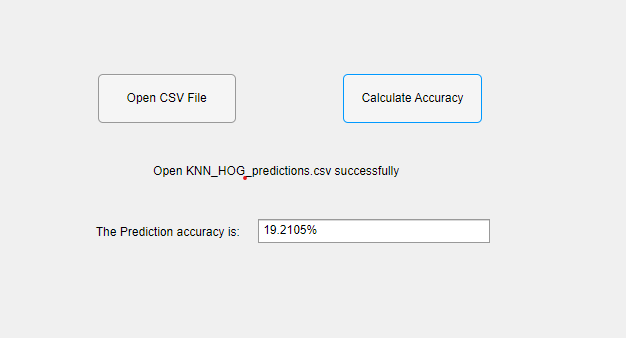

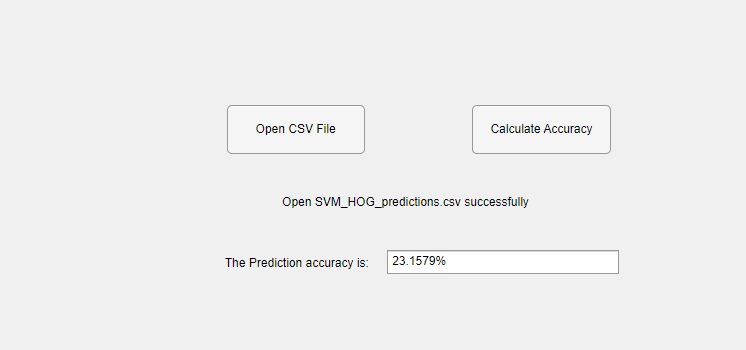

### (2). SVM and 1NN using SIFT features

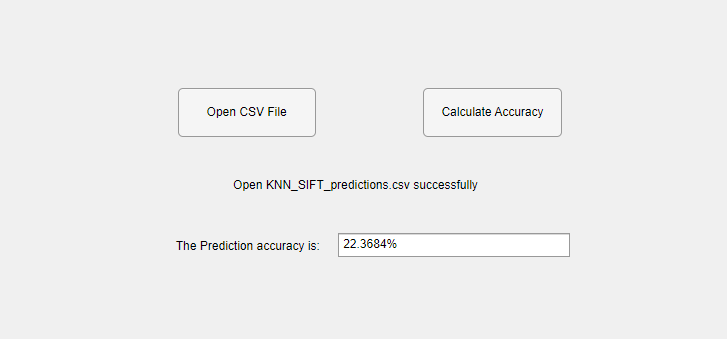

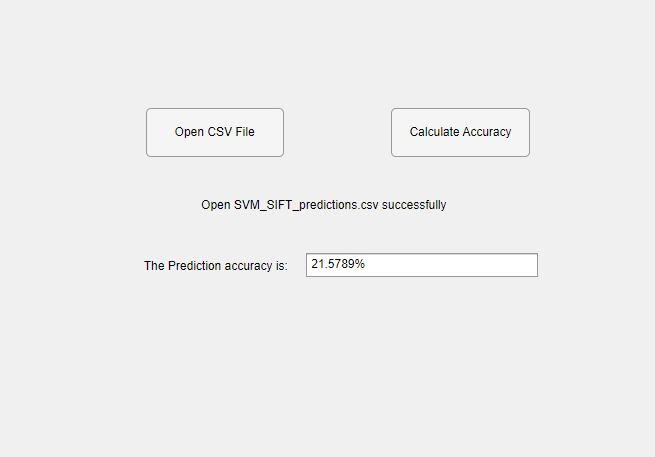

### (3). SVM and 1NN using SURF features( I used orb because my system didnt support surf environment)

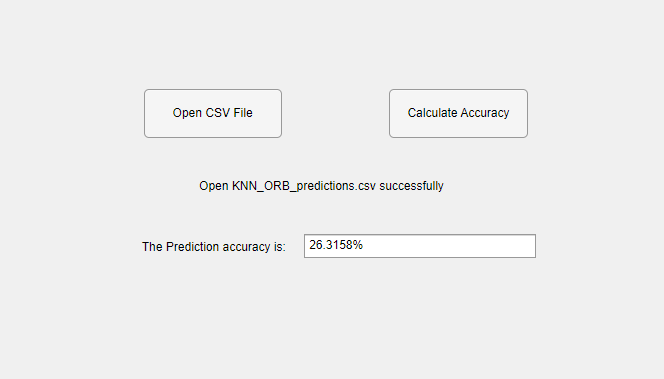

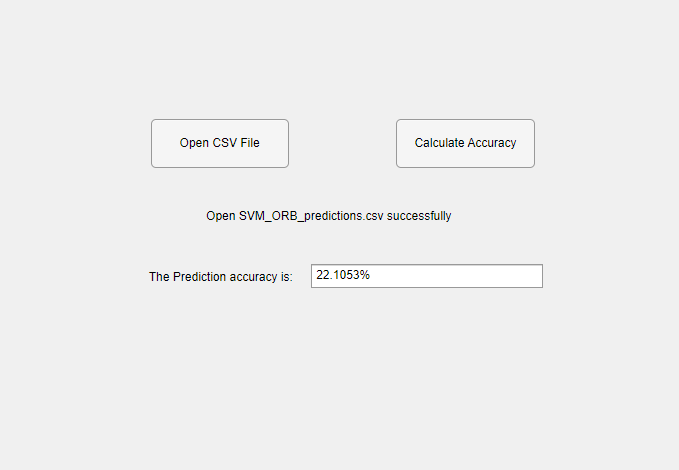